# Semeval 2025 Task 10

## Subtask 1: Entity Framing -- Multilingual

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a predefined taxonomy of fine-grained roles covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

### Using multilingual embeddings, and ML models

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os

In [2]:
data = []
ignore_folders = ['.DS_Store']

base_dir_documents = '../data/semeval_data/train/raw-documents'

for language_folder in os.listdir(base_dir_documents):

    if language_folder in ignore_folders:
        continue

    language_path = os.path.join(base_dir_documents, language_folder)
    if os.path.isdir(language_path):
        for root, _, files in os.walk(language_path):
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)

                    article_id = file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()

                    data.append({
                        'language': language_folder,
                        'article_id': article_id,
                        'content': content
                    })

documents_df = pd.DataFrame(data)

In [3]:
documents_df.shape

(1709, 3)

In [4]:
documents_df.sample(5)

,language,article_id,content
807,BG,A9_BG_2719.txt,Американски политолог: Свалянето на Зеленски и...
1572,EN,EN_CC_100003.txt,"Fonda Heads To Canada For Oil Sands Protest, M..."
1608,EN,EN_UA_300032.txt,Russia Says Britain Blocked Ukraine Peace Deal...
1059,HI,HI_8.txt,शीत युद्ध के बाद रूस-अमेरिका के बीच कैदियों की...
1012,HI,HI_306.txt,"यूक्रेन का पलटवार: रूस के 1,000 वर्ग किलोमीटर ..."


In [5]:
documents_df['article_id'].unique

<bound method Series.unique of 0        RU-URW-1161.txt
1        RU-URW-1175.txt
2        RU-URW-1149.txt
3        RU-URW-1015.txt
4        RU-URW-1001.txt
              ...       
1704    EN_UA_008072.txt
1705    EN_CC_300151.txt
1706    EN_CC_200145.txt
1707    EN_UA_015962.txt
1708    EN_CC_300179.txt
Name: article_id, Length: 1709, dtype: object>

In [6]:
base_dir_labels = '../data/semeval_data/train/labels'

raw_annotation_data = []

for language_folder in os.listdir(base_dir_labels):

    if language_folder in ignore_folders:
        continue

    language_path = os.path.join(base_dir_labels, language_folder)
    if os.path.isdir(language_path):
        for root, _, files in os.walk(language_path):
            label_file = 'subtask-1-annotations.txt'
            file_path = os.path.join(root, label_file)
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    parts = line.strip().split('\t')
                    article_id = parts[0]
                    entity_mention = parts[1]
                    start_offset = int(parts[2])
                    end_offset = int(parts[3])
                    main_role = parts[4]

                    sub_roles = parts[5:]
                    raw_annotation_data.append({
                        "article_id": article_id,
                        "entity_mention": entity_mention,
                        "start_offset": start_offset,
                        "end_offset": end_offset,
                        "main_role": main_role,
                        "sub_roles": sub_roles,
                    })

annotations_df = pd.DataFrame(raw_annotation_data)

In [7]:
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,sub_roles
0,RU-URW-1080.txt,Ермак,155,159,Antagonist,[Incompetent]
1,RU-URW-1080.txt,Трамп,492,496,Protagonist,[Peacemaker]
2,RU-URW-1013.txt,Украины,108,114,Innocent,[Victim]
3,RU-URW-1145.txt,Российские войска,105,121,Protagonist,[Guardian]
4,RU-URW-1145.txt,ВСУ,131,133,Antagonist,[Terrorist]


In [8]:
annotations_df.shape

(5262, 6)

In [9]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles
0,RU,RU-URW-1161.txt,В ближайшие два месяца США будут стремиться к ...,НАТО,173,176,Antagonist,[Foreign Adversary]
1,RU,RU-URW-1161.txt,В ближайшие два месяца США будут стремиться к ...,Украине,262,268,Innocent,[Exploited]
2,RU,RU-URW-1161.txt,В ближайшие два месяца США будут стремиться к ...,Вадим Колесниченко,414,431,Protagonist,[Virtuous]
3,RU,RU-URW-1161.txt,В ближайшие два месяца США будут стремиться к ...,России,1292,1297,Innocent,[Victim]
4,RU,RU-URW-1175.txt,В ЕС испугались последствий популярности правы...,Макрона,3422,3428,Antagonist,[Incompetent]


In [10]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [11]:
dataset['article_id'] = dataset['article_id'].apply(extract_article_id)

In [12]:
print(dataset.iloc[6].content)

Возможность признания Аллы Пугачевой иностранным агентом

"В свете недавних событий вокруг Аллы Пугачевой возник вопрос о возможности признания её иностранным агентом. Этот сложный юридический процесс требует тщательного рассмотрения ряда факторов. Управляющий партнер компании ""Русяев и партнеры"", юрист Илья Русяев, пояснил, что для признания Пугачевой иноагентом необходимо установить наличие иностранного финансирования или влияния. Учитывая её международную известность и связи, можно предположить наличие зарубежных источников дохода. Однако этого недостаточно нужно доказать, что эти средства используются для политической деятельности в России.

Ключевым аспектом в данном случае может стать публичная позиция Пугачевой. Её недавний пост о ситуации в Киеве может быть расценен как распространение информации, дискредитирующей действия российских Вооруженных сил, что может интерпретироваться как политическая деятельность. Для инициирования процесса Министерству юстиции потребуется собрать

In [13]:
print(dataset.iloc[6].entity_mention)

Министерству юстиции


In [14]:
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles
0,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,НАТО,173,176,Antagonist,[Foreign Adversary]
1,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Украине,262,268,Innocent,[Exploited]
2,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Вадим Колесниченко,414,431,Protagonist,[Virtuous]
3,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,России,1292,1297,Innocent,[Victim]
4,RU,RU-URW-1175,В ЕС испугались последствий популярности правы...,Макрона,3422,3428,Antagonist,[Incompetent]


In [15]:
dataset.shape

(5262, 8)

In [16]:
dataset['main_role'].explode().value_counts()

main_role
Antagonist     2435
Protagonist    1759
Innocent       1068
Name: count, dtype: int64

In [17]:
dataset['sub_roles'].explode().value_counts()

sub_roles
Victim               939
Guardian             808
Foreign Adversary    781
Virtuous             493
Instigator           376
Peacemaker           294
Incompetent          293
Tyrant               279
Conspirator          226
Rebel                224
Deceiver             209
Terrorist            201
Underdog             188
Corrupt              157
Exploited            104
Saboteur              82
Bigot                 69
Traitor               49
Scapegoat             33
Forgotten             32
Martyr                31
Spy                   20
Name: count, dtype: int64

In [18]:
dataset.isnull().sum()

language          0
article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
sub_roles         0
dtype: int64

In [19]:
def get_context(row, window=50):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [20]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [21]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

In [22]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [23]:
dataset.drop(columns=['context_before', 'context_after'], inplace=True)
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,НАТО,173,176,Antagonist,[Foreign Adversary],В ближайшие два месяца США будут стремиться к ...
1,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Украине,262,268,Innocent,[Exploited],В ближайшие два месяца США будут стремиться к ...
2,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Вадим Колесниченко,414,431,Protagonist,[Virtuous],стремиться к эскалации конфликта на Украине – ...
3,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,России,1292,1297,Innocent,[Victim],"долг вырос более чем на 7 триллионов долларов""..."
4,RU,RU-URW-1175,В ЕС испугались последствий популярности правы...,Макрона,3422,3428,Antagonist,[Incompetent],"институтами ЕС. Оппозиция """"Национальное объед..."


In [24]:
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,НАТО,173,176,Antagonist,[Foreign Adversary],В ближайшие два месяца США будут стремиться к ...
1,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Украине,262,268,Innocent,[Exploited],В ближайшие два месяца США будут стремиться к ...
2,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Вадим Колесниченко,414,431,Protagonist,[Virtuous],стремиться к эскалации конфликта на Украине – ...
3,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,России,1292,1297,Innocent,[Victim],"долг вырос более чем на 7 триллионов долларов""..."
4,RU,RU-URW-1175,В ЕС испугались последствий популярности правы...,Макрона,3422,3428,Antagonist,[Incompetent],"институтами ЕС. Оппозиция """"Национальное объед..."


In [30]:
!python3 -m spacy download xx_ent_wiki_sm
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 4.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 4.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [31]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 2.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [32]:
language_model_map = {
    "BG": "xx_ent_wiki_sm",
    "EN": "en_core_web_sm",
    "HI": "xx_ent_wiki_sm",
    "PT": "pt_core_news_sm",
    "RU": "ru_core_news_sm",
}

In [33]:
!pip3 install emoji

In [34]:
import spacy
import re
import emoji

nlp_models = {lang: spacy.load(model) for lang, model in language_model_map.items()}

def clean_article(article_text, language_code, entity_mention):
    nlp = nlp_models.get(language_code, nlp_models["EN"])

    article_text = re.sub(
        r'(http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com|'
        r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+|@[A-Za-z0-9_]+)',
        '',
        article_text
    )

    doc = nlp(article_text)

    cleaned_tokens = []
    important_entity_types = ["PERSON", "ORG", "GPE"]

    for token in doc:
        if token.is_space or emoji.is_emoji(token.text):
            continue

        if token.text.lower() == entity_mention.lower():
            cleaned_tokens.append(f"[ENTITY_START] {entity_mention} [ENTITY_END] ")
        else:
            cleaned_tokens.append(token.text.lower() + token.whitespace_)

    return "".join(cleaned_tokens).strip()

dataset["entity_context"] = dataset.apply(
    lambda row: clean_article(row["entity_context"], row["language"], row["entity_mention"]),
    axis=1
)

In [35]:
print(dataset.iloc[6].entity_context)

недостаточно нужно доказать, что эти средства используются для политической деятельности в россии. ключевым аспектом в данном случае может стать публичная позиция пугачевой. её недавний пост о ситуации в киеве может быть расценен как распространение информации, дискредитирующей действия российских вооруженных сил, что может интерпретироваться как политическая деятельность. для инициирования процесса мини министерству юстиции ребуется собрать доказательную базу, включая анализ её финансовых операций, публичных выступлений и постов в социальных сетях. сам факт критических высказываний недостаточен необходимо доказать систематический характер такой деятельности и её связь с иностранным влиянием. если минюст решит включить пугачеву в реестр иноагентов , она получит уведомление и право обжаловать это решение


In [36]:
from sklearn.preprocessing import LabelEncoder

le_main_role = LabelEncoder()
dataset['main_role_encoded'] = le_main_role.fit_transform(dataset['main_role'])

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_sub_role = MultiLabelBinarizer()
dataset.loc[:, 'sub_roles_encoded'] = list(mlb_sub_role.fit_transform(dataset['sub_roles']))

print(dataset.shape)
dataset.head()

(5262, 11)


,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context,main_role_encoded,sub_roles_encoded
0,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,НАТО,173,176,Antagonist,[Foreign Adversary],в ближайшие два месяца сша будут стремиться к ...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Украине,262,268,Innocent,[Exploited],в ближайшие два месяца сша будут стремиться к ...,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,Вадим Колесниченко,414,431,Protagonist,[Virtuous],стремиться к эскалации конфликта на украине – ...,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,RU,RU-URW-1161,В ближайшие два месяца США будут стремиться к ...,России,1292,1297,Innocent,[Victim],"долг вырос более чем на 7 триллионов долларов""...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,RU,RU-URW-1175,В ЕС испугались последствий популярности правы...,Макрона,3422,3428,Antagonist,[Incompetent],"институтами ес. оппозиция """"национальное объед...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [38]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/LaBSE')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the 

In [39]:
texts = [
    "This is a news article about politics.",  # English
    "यह राजनीति के बारे में एक समाचार लेख है।",  # Hindi
    "Este é um artigo de notícias sobre política.",  # Portuguese
    "Това е новинарска статия за политика.",  # Bulgarian
    "The sun rises in the east."  # Unrelated English sentence
]

In [40]:
embeddings = model.encode(texts)

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)

print("Cosine Similarity Matrix:")
print(cos_sim_matrix)

Cosine Similarity Matrix:
[[1.         0.8829176  0.9265815  0.8651781  0.19801825]
 [0.8829176  1.0000002  0.96578115 0.89237857 0.23692542]
 [0.9265815  0.96578115 1.0000002  0.9107212  0.21260464]
 [0.8651781  0.89237857 0.9107212  1.0000002  0.18266794]
 [0.19801825 0.23692542 0.21260464 0.18266794 1.        ]]


In [42]:
!pip install -q iterative-stratification

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

def stratified_train_val_split(data, labels_column, train_size=0.8, splits=5, shuffle=True, min_instances=2):
    if shuffle:
        shuffled_indices = np.arange(len(data))
        np.random.shuffle(shuffled_indices)
        data = data.iloc[shuffled_indices].reset_index(drop=True)

    labels = np.array(data[labels_column].tolist())
    rare_indices = []
    common_indices = []

    class_counts = labels.sum(axis=0)
    rare_classes = np.where(class_counts <= min_instances)[0]

    for idx, label_row in enumerate(labels):
        if any(label_row[rare_classes]):
            rare_indices.append(idx)
        else:
            common_indices.append(idx)

    rare_data = data.iloc[rare_indices]
    rare_labels = labels[rare_indices]
    train_rare = rare_data.iloc[:len(rare_data) // 2].reset_index(drop=True)
    val_rare = rare_data.iloc[len(rare_data) // 2:].reset_index(drop=True)

    common_data = data.iloc[common_indices].reset_index(drop=True)
    common_labels = labels[common_indices]

    mskf = MultilabelStratifiedKFold(n_splits=splits)
    for train_idx, val_idx in mskf.split(np.zeros(len(common_labels)), common_labels):
        train_common = common_data.iloc[train_idx]
        val_common = common_data.iloc[val_idx]
        break

    train_data = pd.concat([train_rare, train_common]).reset_index(drop=True)
    val_data = pd.concat([val_rare, val_common]).reset_index(drop=True)

    return train_data, val_data

(dataset_train), (dataset_val) = stratified_train_val_split(
    dataset,
    labels_column="sub_roles_encoded",
    min_instances=2
)

In [48]:
dataset_train.shape

(4215, 11)

In [49]:
dataset_val.shape

(1047, 11)

In [50]:
def get_embeddings_multilingual(dataset):
    embeddings = []
    for index, row in dataset.iterrows():
        content = row['entity_context']
        embedding = model.encode(content)
        combined_embedding = np.concatenate([embedding])
        embeddings.append(combined_embedding)
    embeddings_array = np.array(embeddings)
    return embeddings_array

In [51]:
def prepare_data(train_data, val_data):
    train_embeddings = get_embeddings_multilingual(train_data)
    val_embeddings = get_embeddings_multilingual(val_data)

    return train_embeddings, val_embeddings

In [52]:
train_embeddings, val_embeddings = prepare_data(dataset_train, dataset_val)

In [53]:
y_train_main_encoded = np.array(dataset_train['main_role_encoded'].tolist())
y_val_main_encoded = np.array(dataset_val['main_role_encoded'].tolist())

In [54]:
y_train_sub_encoded = np.array(dataset_train['sub_roles_encoded'].tolist())
y_val_sub_encoded = np.array(dataset_val['sub_roles_encoded'].tolist())

In [55]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [56]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [57]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.53102614 0.55565229 0.55260466]
Mean CV F1 Score: 0.5464276947696124


In [58]:
knn_classifier.fit(train_embeddings, y_train_main_encoded)

KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

              precision    recall  f1-score      support
0              0.596421  0.626305  0.610998   479.000000
1              0.440529  0.471698  0.455581   212.000000
2              0.570978  0.508427  0.537890   356.000000
accuracy       0.554919  0.554919  0.554919     0.554919
macro avg      0.535976  0.535477  0.534823  1047.000000
weighted avg   0.556204  0.554919  0.554671  1047.000000




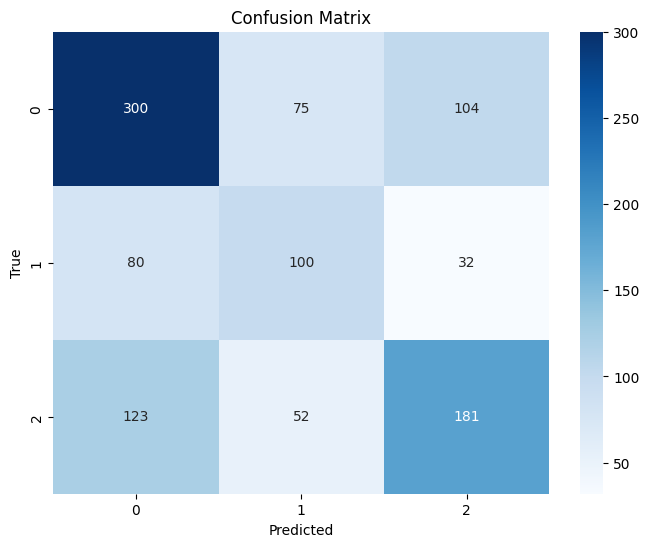

array([[300,  75, 104],
       [ 80, 100,  32],
       [123,  52, 181]])

In [59]:
evaluate_model(knn_classifier, val_embeddings, y_val_main_encoded)

In [60]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

get_cross_val_score(logreg, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.5461387  0.55550506 0.54858969]
Mean CV F1 Score: 0.5500778181257738


In [61]:
logreg.fit(train_embeddings, y_train_main_encoded)

LogisticRegression(class_weight='balanced', max_iter=1000)

              precision    recall  f1-score      support
0              0.666667  0.555324  0.605923   479.000000
1              0.419795  0.580189  0.487129   212.000000
2              0.591549  0.589888  0.590717   356.000000
accuracy       0.572111  0.572111  0.572111     0.572111
macro avg      0.559337  0.575133  0.561256  1047.000000
weighted avg   0.591138  0.572111  0.576699  1047.000000




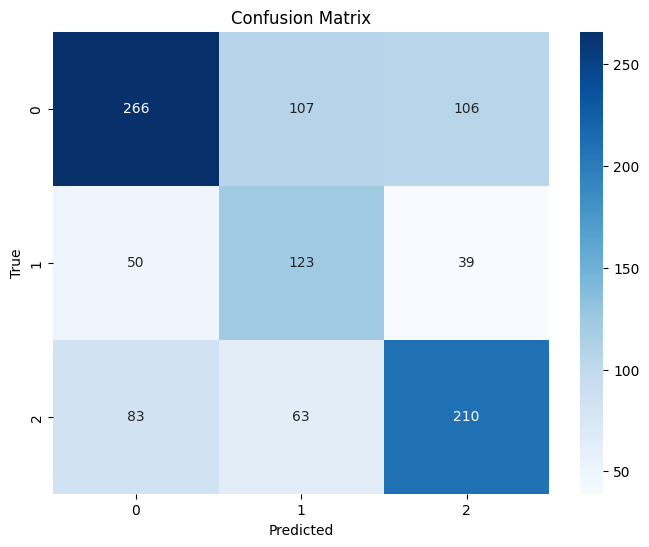

array([[266, 107, 106],
       [ 50, 123,  39],
       [ 83,  63, 210]])

In [62]:
evaluate_model(logreg, val_embeddings, y_val_main_encoded)

In [63]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.57476447 0.58055139 0.56973754]
Mean CV F1 Score: 0.5750178018629591


In [ ]:
xgb_classifier.fit(train_embeddings, y_train_main_encoded)
evaluate_model(xgb_classifier, val_embeddings, y_val_main_encoded)

In [ ]:
from collections import Counter
Counter(y_train_main_encoded)

In [ ]:
from sklearn.utils import class_weight

classes = np.unique(y_train_main_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_main_encoded)
class_weights

In [ ]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

In [ ]:
sample_weights = np.array([class_weights_dict[label] for label in y_train_main_encoded])
sample_weights[:15]

              precision    recall  f1-score     support
0              0.676923  0.721311  0.698413  183.000000
1              0.655738  0.500000  0.567376   80.000000
2              0.625899  0.659091  0.642066  132.000000
accuracy       0.655696  0.655696  0.655696    0.655696
macro avg      0.652853  0.626801  0.635952  395.000000
weighted avg   0.655581  0.655696  0.653044  395.000000




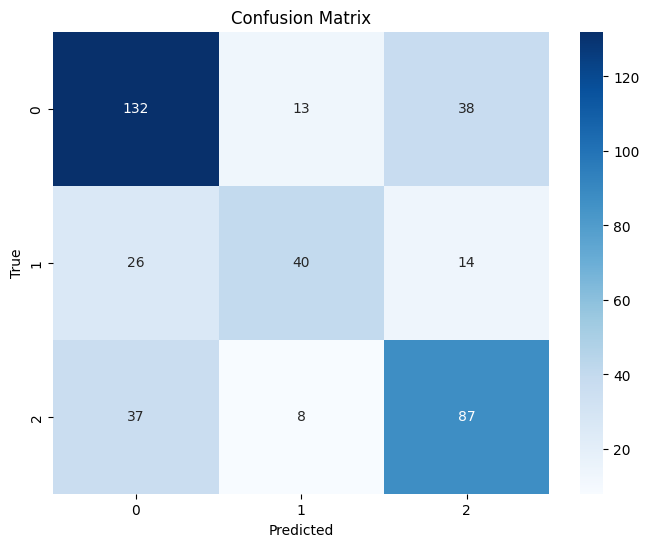

array([[132,  13,  38],
       [ 26,  40,  14],
       [ 37,   8,  87]])

In [58]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
xgb_weighted.fit(train_embeddings, y_train_main_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_embeddings, y_val_main_encoded)

In [59]:
y_pred = xgb_weighted.predict(val_embeddings)
misclassified_indices = np.where(y_pred != y_val_main_encoded)[0]

In [60]:
misclassified_indices

array([  1,   4,   8,   9,  10,  18,  20,  22,  24,  28,  35,  45,  47,
        49,  51,  54,  56,  58,  63,  64,  68,  69,  74,  75,  77,  78,
        81,  85,  89,  92,  95,  96,  99, 103, 111, 112, 117, 127, 130,
       132, 134, 136, 137, 143, 145, 149, 153, 157, 158, 159, 165, 167,
       168, 172, 173, 176, 177, 184, 187, 194, 200, 206, 207, 208, 211,
       214, 216, 224, 225, 229, 231, 232, 237, 239, 242, 243, 244, 245,
       249, 251, 253, 261, 262, 263, 266, 267, 268, 269, 270, 272, 276,
       278, 279, 281, 282, 286, 291, 294, 295, 297, 300, 303, 307, 308,
       317, 319, 321, 324, 325, 326, 329, 332, 335, 337, 339, 342, 343,
       344, 347, 350, 352, 353, 356, 359, 362, 365, 368, 373, 378, 381,
       382, 383, 385, 386, 387, 388])

In [61]:
true_labels_decoded = le_main_role.inverse_transform(y_val_main_encoded)
predicted_labels_decoded = le_main_role.inverse_transform(y_pred)

In [62]:
misclassified_articles = []

for idx in misclassified_indices:
    misclassified_articles.append({
        "article_id": idx,
        "true_label": true_labels_decoded[idx],
        "predicted_label": predicted_labels_decoded[idx],
        "context": dataset_val.iloc[idx]["entity_context"],
        "language": dataset_val.iloc[idx]["language"],
        "entity_mention": dataset_val.iloc[idx]["entity_mention"]
    })

misclassified_df = pd.DataFrame(misclassified_articles)

In [63]:
misclassified_df.head()

,article_id,true_label,predicted_label,context,language,entity_mention
0,1,Innocent,Antagonist,"добави, че позицията на президента на франция ...",BG,Европа
1,4,Antagonist,Innocent,"глава мид фрг заявила, что путин хочет пошатну...",RU,Анналена Бербок
2,8,Innocent,Protagonist,"पुतिन से कहा, ""भारत ने हमेशा क्षेत्रीय अखंडता ...",HI,भारतीयों
3,9,Antagonist,Protagonist,não queremos que o conflito na ucrânia se tran...,PT,Emmanuel Macron
4,10,Protagonist,Antagonist,"militar zvezda, citado pelo moscow times. pesk...",PT,Moscovo


In [64]:
misclassified_df_en = misclassified_df[misclassified_df['language'] == "EN"]

for _, row in misclassified_df_en.iterrows():
    print(f"Entity Mention: {row['entity_mention']}")
    print(f"True Label: {row['true_label']} | Predicted Label: {row['predicted_label']}")
    print(f"Context: {row['context']}")
    print("=" * 80)

Entity Mention: Iraq
True Label: Innocent | Predicted Label: Antagonist
Context: and warmonger propagandist max boot weighed in on the meaningless and unenforcible decision to arrest president putin. boot’s argument is delusional, but then neocons thrive on lies and delusions. truth lives on at propaganda, pure and simple. boot is an accessory to mass murder, having advocated the invasion of [ENTITY_START] Iraq [ENTITY_END] , the slaughter of over a million iraqis, and the engineered destruction of their country. the hypocritical icc didn’t bother to contrast and compare putin’s supposed abduction of ukrainian children to an organized mass kidnapping of vietnamese children. it was dubbed “operation babylift,” ordered by then president ford, and was
Entity Mention: Biden administration
True Label: Protagonist | Predicted Label: Antagonist
Context: senate blocks sanctions aimed at stopping nord stream 2 pipeline the senate blocked a measure to impose new sanctions on the nord stream 2 ga

### Using Roberta to classify main roles

In [65]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [66]:
def tokenize_data(entity_contexts, max_length=512):
    encodings = tokenizer(entity_contexts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    return encodings

In [67]:
train_encodings = tokenize_data(dataset_train['entity_context'].tolist())
val_encodings = tokenize_data(dataset_val['entity_context'].tolist())

In [68]:
train_main_roles_truths = dataset_train['main_role_encoded'].tolist()

train_main_roles_truths[:5]

[0, 1, 2, 0, 2]

In [69]:
val_main_roles_truths = dataset_val['main_role_encoded'].tolist()

val_main_roles_truths[:5]

[0, 0, 0, 0, 0]

In [70]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss

model_config = {
    'batch_size': 16,
    'num_epochs': 5,
    'lr': 3e-5
}

In [ ]:
from transformers import XLMRobertaModel
import torch.nn as nn

class MultilingualRoleClassifier(nn.Module):
    def __init__(self, main_roles_len):
        super(MultilingualRoleClassifier, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.classifier = nn.Linear(self.backbone.config.hidden_size, main_roles_len)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        main_role_logits = self.classifier(pooled_output)
        return main_role_logits

In [ ]:
class EntityContextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'main_role_labels': self.labels[idx]
        }

train_dataset = EntityContextDataset(
                              input_ids=train_encodings['input_ids'],
                              attention_mask=train_encodings['attention_mask'],
                             labels=train_main_roles_truths
                            )

val_dataset = EntityContextDataset(
                              input_ids=val_encodings['input_ids'],
                             attention_mask=val_encodings['attention_mask'],
                             labels=val_main_roles_truths
                            )

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=model_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=model_config['batch_size'])

In [ ]:
model = MultilingualRoleClassifier(main_roles_len=len(le_main_role.classes_))
optimizer = optim.AdamW(model.parameters(), lr=model_config['lr'])
criterion = CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_loader) * model_config['num_epochs']
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [ ]:
def freeze_roberta_layers(model, num_layers_to_freeze=2):
  assert hasattr(model, 'classifier'), "Model must have a classifier attribute"
  for i in range(num_layers_to_freeze):
    for param in model.backbone.encoder.layer[i].parameters():
      param.requires_grad = False

  for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
freeze_roberta_layers(model)

In [ ]:
import torch

def train(train_loader, val_loader, model, optimizer, criterion, label, scheduler=None, num_epochs=10, patience=3, device='cuda'):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch[label].to(device)
            logits = model(input_ids, attention_mask)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch[label].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss (Avg): {avg_train_loss:.4f}, Val Loss (Avg): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training after {epoch+1} epochs.")
            break

In [ ]:
train(train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer, criterion=criterion, label='main_role_labels', scheduler=scheduler)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_transformer_model(
    model,
    val_loader,
    label_column,
    device='cuda',
    target_names=None
):
    model.eval()

    all_preds = []
    all_truths = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch[label_column].to(device)

            logits = model(input_ids, attention_mask)

            probs = torch.softmax(logits, dim=-1)
            model_preds = torch.argmax(probs, dim=-1)

            all_preds.extend(model_preds.cpu().numpy())
            all_truths.extend(labels.cpu().numpy())

    classification_rep = classification_report(all_truths, all_preds, target_names=target_names, zero_division=0)
    current_f1 = f1_score(all_truths, all_preds, average='macro')
    micro_f1 = f1_score(all_truths, all_preds, average='micro')

    print("Classification Report:")
    print(classification_rep)
    print(f"F1 Score (Macro Average): {current_f1}")
    print(f"F1 Score (Micro Average): {micro_f1}")

    accuracy = (np.array(all_preds) == np.array(all_truths)).mean()
    print(f"Accuracy: {accuracy}")

    conf_matrix = confusion_matrix(all_truths, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

In [ ]:
evaluate_transformer_model(
    model,
    val_loader,
    label_column='main_role_labels',
    device='cuda',
    target_names=le_main_role.classes_
)

### Using Roberta to classify sub roles

In [ ]:
train_sub_roles_truth = dataset_train['sub_roles_encoded'].tolist()

train_sub_roles_truth[:5]

In [ ]:
val_sub_roles_truth = dataset_val['sub_roles_encoded'].tolist()

val_sub_roles_truth[:5]

In [ ]:
from transformers import XLMRobertaModel
import torch.nn as nn

class MultilingualSubRoleClassifier(nn.Module):
    def __init__(self, sub_roles_len):
        super(MultilingualSubRoleClassifier, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.classifier = nn.Linear(self.backbone.config.hidden_size, sub_roles_len)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        sub_roles_logits = self.classifier(pooled_output)
        return sub_roles_logits

In [ ]:
class SubRoleDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'sub_role_labels': self.labels[idx].astype(np.float32)
        }

train_dataset_sbr = SubRoleDataset(
                              input_ids=train_encodings['input_ids'],
                              attention_mask=train_encodings['attention_mask'],
                              labels=train_sub_roles_truth
                            )

val_dataset_sbr = SubRoleDataset(
                              input_ids=val_encodings['input_ids'],
                              attention_mask=val_encodings['attention_mask'],
                              labels=val_sub_roles_truth
                            )

In [ ]:
train_loader_sbr = DataLoader(train_dataset_sbr, batch_size=model_config['batch_size'], shuffle=True)
val_loader_sbr = DataLoader(val_dataset_sbr, batch_size=model_config['batch_size'], shuffle=False)

In [ ]:
sbr_model = MultilingualSubRoleClassifier(sub_roles_len=len(mlb_sub_role.classes_))

In [ ]:
from torch.nn import BCEWithLogitsLoss

model_config = {
    'batch_size': 16,
    'num_epochs': 10,
    'lr': 4e-5
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer_sbr = optim.AdamW(sbr_model.parameters(), lr=model_config['lr'])
criterion_sbr = BCEWithLogitsLoss()

sbr_model.to(device)

In [ ]:
from transformers import get_scheduler

num_training_steps = len(train_loader_sbr) * model_config['num_epochs']
scheduler_sbr = get_scheduler(
    "linear",
    optimizer=optimizer_sbr,
    num_warmup_steps=0.1 * num_training_steps,
    num_training_steps=num_training_steps,
)

In [ ]:
train(train_loader_sbr, val_loader_sbr, sbr_model, optimizer_sbr, criterion_sbr, 'sub_role_labels', scheduler=scheduler_sbr)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_transformer_model(
    model,
    val_loader,
    label_column,
    thresholds=np.arange(0.1, 1.0, 0.1),
    device='cuda',
    target_names=None
):
    best_threshold = 0
    best_f1 = 0
    best_classification_report = None

    all_preds = []
    all_truths = []

    for threshold in thresholds:
        preds = []
        truths = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch[label_column].to(device)
                logits = model(input_ids, attention_mask)
                probs = torch.sigmoid(logits)

                model_preds = (probs >= threshold).int()
                preds.extend(model_preds.cpu().numpy())
                truths.extend(labels.cpu().numpy())

        classification_rep = classification_report(truths, preds, target_names=target_names, zero_division=0)
        current_f1 = f1_score(truths, preds, average='macro')

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_classification_report = classification_rep

    print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")
    print("Best Classification Report:")
    print(best_classification_report)

In [ ]:
evaluate_transformer_model(sbr_model, val_loader_sbr, label_column='sub_role_labels', device='cuda', target_names=mlb_sub_role.classes_)